In [6]:
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy.io
import os
import anndata as ad # Anndata version must > 0.8
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

from scATAnno.SnapATAC2_spectral import *
from scATAnno.SnapATAC2_tools import *
from scATAnno.SnapATAC2_utils import *
from scATAnno import scATAnno_preprocess
from scATAnno import scATAnno_assignment
from scATAnno import scATAnno_integration
from scATAnno import scATAnno_plotting

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

default_28 = scATAnno_plotting.get_palettes("default28")
default_102 = scATAnno_plotting.get_palettes("default102")

# TNBC sample

Download TIL reference data

In [1]:
# !wget "https://www.dropbox.com/s/ky4jezsj3pf2qwi/BCC_TIL_reference_atlas_final.h5ad?dl=1"

Download TNBC query data

In [2]:
# !wget "https://www.dropbox.com/sh/gbsbnnfdiz2figa/AADmAJvg2i6nz6sINF0RXThqa?dl=1"

In [8]:
os.chdir("scATAnno-main")

output_name = "TNBC"
out_dir = os.path.join("case_study", output_name) 



In [3]:

reference_data_path = "data/Reference/BCC_TIL_reference_atlas_final.h5ad"
reference_data = scATAnno_preprocess.load_reference_data(reference_data_path)
query_data = scATAnno_preprocess.import_query_data(path = 'data/TNBC_Pre_P012_t/',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv.gz',
                                    features_file = 'features.tsv.gz', 
                                    variable_prefix = "TNBC_Pre_P012_t", 
                                    celltype_col = "celltypes",
                                    add_metrics=False)

In [4]:
print(reference_data)
print(query_data)
assert reference_data.var.shape[0] == query_data.var.shape[0]

AnnData object with n_obs × n_vars = 22008 × 344492
    obs: 'celltypes', 'tissue', 'dataset'
    var: 'selected'
    uns: 'Group_colors', 'celltypes_colors', 'spectral_eigenvalue', 'true_label_colors'
    obsm: 'X_spectral', 'X_umap'
View of AnnData object with n_obs × n_vars = 9935 × 344492
    obs: 'celltypes', 'tissue', 'dataset'


In [5]:
# Integrate reference and query data
integrated_adata = scATAnno_assignment.scATAnno_integrate(reference_data, query_data, variable_prefix = "TNBC_Pre_P012_t", sample_size = 25000)

/Users/jiang/Dropbox (Partners HealthCare)/Software/ATAC_Annotation_V3/ATAC_Annotation_Package/scATAnno/SnapATAC2_spectral.py:159: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["selected"] = selected_features


Compute similarity matrix
Normalization
Perform decomposition
Perform Nystrom extension


100%|████████████████████████████████████████████| 2/2 [04:20<00:00, 130.26s/it]


In [6]:
# Apply harmony to remove batch effects
integrated_adata_harmony = scATAnno_assignment.scATAnno_harmony(integrated_adata, batch_col = "dataset")

2023-05-25 17:42:14,786 - harmonypy - INFO - Iteration 1 of 20
2023-05-25 17:42:21,018 - harmonypy - INFO - Iteration 2 of 20
2023-05-25 17:42:26,180 - harmonypy - INFO - Converged after 2 iterations


In [7]:
# Plot UMAP using spectral embeddings
integrated_adata = scATAnno_assignment.scATAnno_umap(integrated_adata_harmony, out_dir, use_rep = "X_spectral_harmony", save = True)
integrated_adata

AnnData object with n_obs × n_vars = 31943 × 344492
    obs: 'celltypes', 'tissue', 'dataset'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap'

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


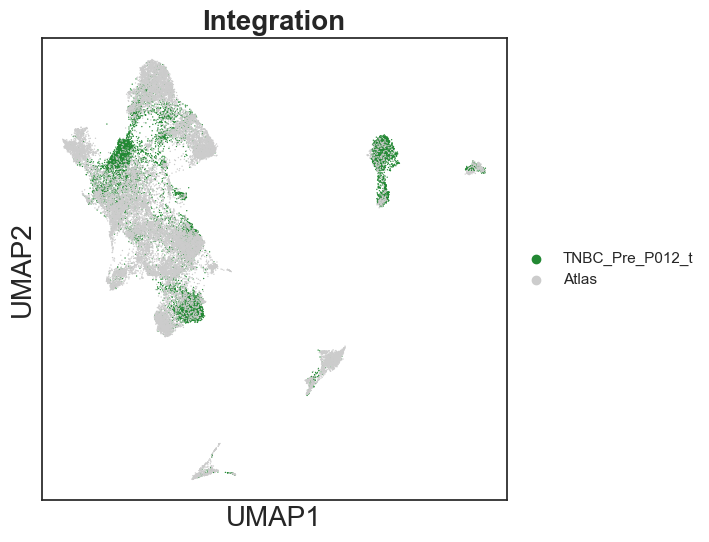

In [8]:
scATAnno_plotting.defaultPlotting_umap()
sc.pl.umap(integrated_adata, color="dataset", palette = ['#228833', '#cccccc'], show=True, title = "Integration")

In [17]:
integrated_adata = sc.read_h5ad(os.path.join(out_dir, "1.Merged_query_reference.h5ad"))
integrated_adata = scATAnno_preprocess.add_variable(os.path.join(out_dir,"X_spectral_harmony.csv"), integrated_adata)

In [18]:
reference = integrated_adata[integrated_adata.obs['dataset'] == "Atlas",:].copy()
reference.obs["celltypes"] =  scATAnno_assignment.curate_celltype_names(reference.obs["celltypes"], atlas = "TIL")

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


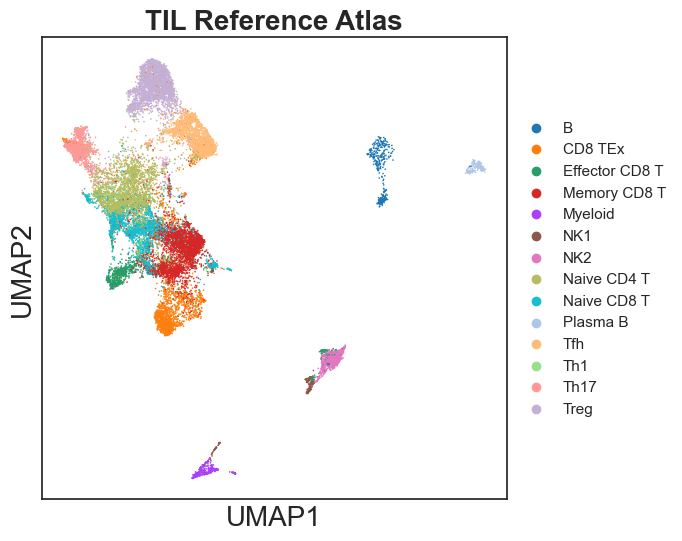

In [11]:
import pickle
with open(os.path.join(out_dir, 'TIL_reference_palette.pickle'), 'rb') as handle:
    celltype_palette = pickle.load(handle)

scATAnno_plotting.defaultPlotting_umap()
sc.pl.umap(reference, color="celltypes", palette = celltype_palette, title = "TIL Reference Atlas")

In [19]:
query = integrated_adata[integrated_adata.obs['dataset'] != "Atlas",:].copy()

In [20]:
projecton = pd.read_csv(os.path.join("data/TNBC_Pre_P012_t/", "query_metadata.csv"), index_col=0)
query.obs = pd.merge(query.obs, projecton, left_index=True, right_index=True)

We first assign cell types based on KNN and compute KNN-based uncertainty score

In [21]:
# Perform KNN assignment
reference_label_col = "celltypes"
use_rep = "X_spectral_harmony"
query_KNN = scATAnno_assignment.scATAnno_KNN_assign(reference, query, reference_label_col=reference_label_col, low_dim_col=use_rep)

Because we are annotating TIL subtypes, we adopt more loose threshold cutoffs to annotate query cells. Query cells are assigned high weighted distance-based uncertainty score if their distances to the assigned reference cell type centroid are greater than 95 percentile. Query cells with uncertainty score greater than 0.5 are annotated as unknown.

In [22]:
# Perform weighted-distance based assignment
distance_threshold = 95
uncertainty_threshold = 0.5

atlas = "TIL"
query_distance = scATAnno_assignment.scATAnno_distance_assign(reference, query_KNN, reference_label_col=reference_label_col, distance_threshold=distance_threshold, atlas=atlas, uncertainty_threshold=uncertainty_threshold, use_rep = use_rep)

Finally, we perform cluster-level assignment of query cells.

In [23]:
query_annotated = scATAnno_assignment.scATAnno_cluster_assign(query_distance, use_rep=use_rep, cluster_col = "Clusters")

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


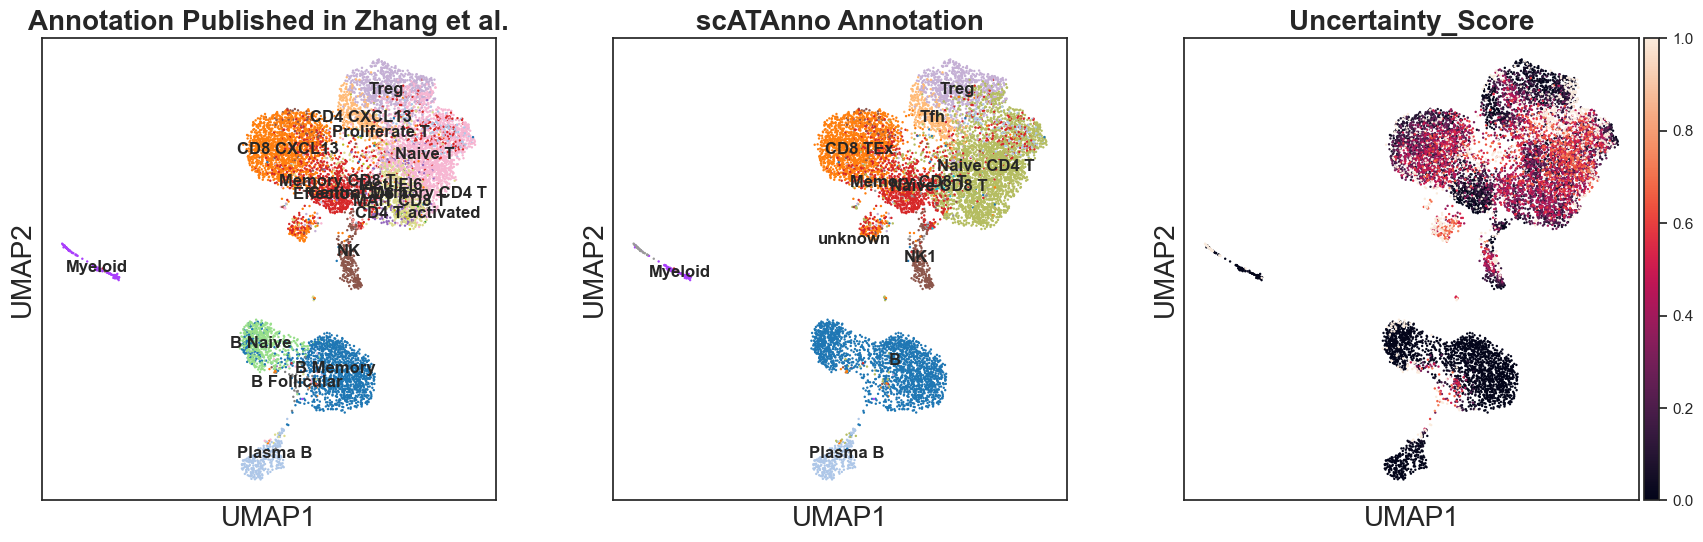

In [24]:
import pickle
with open(os.path.join(out_dir, 'all_palette_dictionary.pkl'), 'rb') as handle:
    annotation_palette = pickle.load(handle)
sc.pl.umap(query_annotated, color = ["paper_annotation_curated", "cluster_annotation", 'Uncertainty_Score'], palette=annotation_palette,title = ["Annotation Published in Zhang et al.","scATAnno Annotation"],  legend_loc = "on data")

Compare the annotation results between scATAnno and original publication.

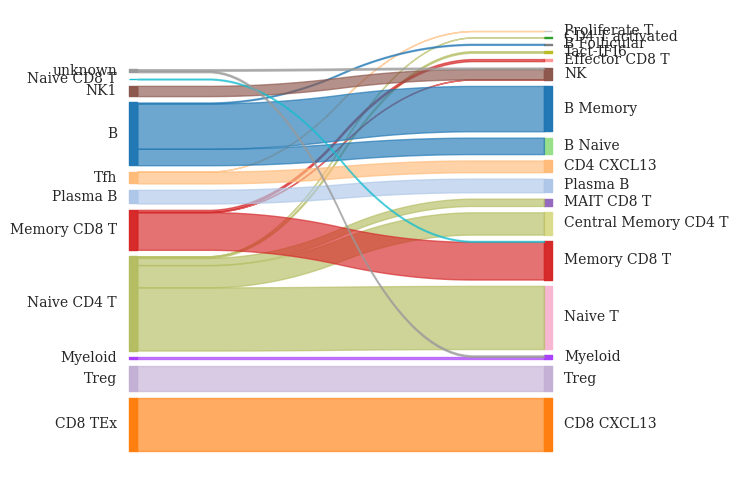

In [25]:
from pySankey.sankey import sankey

pred_col = 'cluster_annotation'
true_col = 'paper_annotation_curated'

sankey(
    query_annotated.obs[pred_col], query_annotated.obs[true_col], aspect=10, colorDict=annotation_palette,
    fontsize=10, figure_name=None
    )

# plt.gcf().set_size_inches(6, 10)
# plt.savefig(os.path.join(out_dir,"{}.png".format("Sankey_CellType_Annotation_paper_cluster")), bbox_inches='tight', dpi=300)
